# MODFLOW-2005 + FloPy Tutorial: **DIS** (Discretization) Package

This notebook is dedicated to the **DIS** package (spatial + temporal discretization).  
We’ll use a very simple “box” model so we can focus on what **DIS inputs mean** and how they change the grid and time stepping.

> **Note:** To *run* MODFLOW, we will include minimal “supporting packages” (BAS6, LPF, RCH, OC, PCG).  
> We won’t explain those deeply here—each will get its own notebook later.

## Learning goals

By the end you should be able to:
1. Explain what **nlay, nrow, ncol, delr, delc, top, botm** do (and how they relate to cell geometry).
2. Explain what **nper, perlen, nstp, tsmult, steady** do (and how they control time discretization).
3. Build/modify DIS inputs in FloPy and **inspect the generated `.dis` file**.
4. Visualize top surface, bottoms, and **layer thickness**.
5. Perform quick “what-if” changes (add layers, refine grid, change stress periods).

## DIS package: what it controls

### A) Spatial discretization (grid geometry)
- **nlay, nrow, ncol**: number of layers/rows/columns (3D grid dimensions)
- **delr**: cell width in the x-direction (length `ncol`) or a scalar
- **delc**: cell width in the y-direction (length `nrow`) or a scalar
- **top**: top elevation of layer 1 (shape `(nrow, ncol)` or scalar)
- **botm**: bottom elevation(s) for each layer (shape `(nlay, nrow, ncol)` or a list)
- **laycbd**: indicates confining beds between layers (advanced use; optional)

### B) Temporal discretization (stress periods + timesteps)
- **nper**: number of stress periods
- **perlen**: length of each stress period
- **nstp**: number of time steps in each stress period
- **tsmult**: time step multiplier within a stress period (1.0 = uniform steps)
- **steady**: list of booleans, one per stress period (`True` for steady-state, `False` for transient)

### C) Units in MODFLOW-2005 (as used by DIS)
- **lenuni**: length units (e.g., 2 = meters)
- **itmuni**: time units (e.g., 4 = days)

The important thing is **consistency**: if K is in m/day, then `lenuni=meters` and `itmuni=days` matches.

In [43]:

# 1) Imports and environment
import os
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import flopy

### Choose (or detect) a MODFLOW-2005 executable

- If you have MODFLOW installed, set the executable path below.
- If the executable is not found, you can still run everything **except** `run_model()`—the DIS concepts and file-writing still work.

In [44]:

# Set this to your MODFLOW-2005 executable name/path.
# Examples:
#   mf_exe = "mf2005"
#   mf_exe = r"C:\path\to\mf2005.exe"
mf_exe = os.environ.get("MF2005_EXE", "mf2005")

exe_found = shutil.which(mf_exe) is not None or Path(mf_exe).exists()
print("MODFLOW executable:", mf_exe)
print("Executable found?  ", exe_found)

MODFLOW executable: mf2005
Executable found?   False


## 2) Define a simple model domain (matching your class “box model” style)

We’ll use:
- **50 × 50** rows/cols
- **dx = dy = 100 m**
- A sloping top surface (generated if no `top_elev.csv` is present)
- A base elevation `zbot = 0 m`

This is similar to the “starter layered” model you described, but we keep the topography creation self-contained.

Generated a synthetic sloping top surface.


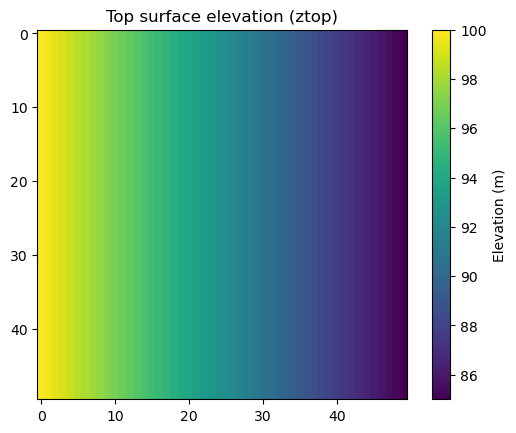

In [45]:

# --- Spatial size ---
nrow, ncol = 50, 50
dx, dy = 100.0, 100.0

Lx = ncol * dx
Ly = nrow * dy

# --- Top surface ---
# If you have a top_elev.csv in your folder, you can load it.
# Otherwise, we generate a simple linear slope (left high -> right low).
top_csv = Path("top_elev.csv")

if top_csv.exists():
    ztop = np.genfromtxt(top_csv, delimiter=",")
    assert ztop.shape == (nrow, ncol), f"Expected {(nrow,ncol)}; got {ztop.shape}"
    print("Loaded top surface from:", top_csv)
else:
    z_left, z_right = 100.0, 85.0
    x = np.linspace(z_left, z_right, ncol)
    ztop = np.tile(x, (nrow, 1))
    print("Generated a synthetic sloping top surface.")

zbot = 0.0

# quick look
plt.figure()
plt.title("Top surface elevation (ztop)")
plt.imshow(ztop)
plt.colorbar(label="Elevation (m)")
plt.show()

## 3) Build DIS for a **one-layer** steady-state model

We’ll start with:
- **nlay = 1**
- **nper = 1** (one stress period)
- **steady = True**
- **itmuni = 4 (days)**, **lenuni = 2 (meters)**

Then we’ll **inspect** the arrays DIS created.

In [46]:

# --- Time discretization ---
nper = 1
perlen = [1.0]     # 1 day (arbitrary for steady state, but required)
nstp   = [1]
tsmult = [1.0]
steady = [True]

# --- Vertical discretization ---
nlay = 1
botm = np.zeros((nlay, nrow, ncol))
botm[0, :, :] = zbot  # bottom of layer 1

# --- Model object ---
workspace = Path("dis_tutorial_ws")
workspace.mkdir(exist_ok=True)

m = flopy.modflow.Modflow(
    modelname="dis_1layer_demo",
    exe_name=mf_exe,
    model_ws=str(workspace),
)

# --- DIS package ---
dis = flopy.modflow.ModflowDis(
    model=m,
    nlay=nlay, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy,
    top=ztop,
    botm=botm,
    nper=nper, perlen=perlen, nstp=nstp, tsmult=tsmult, steady=steady,
    itmuni=4, lenuni=2,
)

print(dis)


    MODFLOW Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.Modflow`) to which
        this package will be added.
    nlay : int
        Number of model layers (the default is 1).
    nrow : int
        Number of model rows (the default is 2).
    ncol : int
        Number of model columns (the default is 2).
    nper : int
        Number of model stress periods (the default is 1).
    delr : float or array of floats (ncol), optional
        An array of spacings along a row (the default is 1.0).
    delc : float or array of floats (nrow), optional
        An array of spacings along a column (the default is 0.0).
    laycbd : int or array of ints (nlay), optional
        An array of flags indicating whether or not a layer has a Quasi-3D
        confining bed below it. 0 indicates no confining bed, and not zero
        indicates a confining bed. LAYCBD for the bottom layer must be 0. (the
    

### Inspect the DIS inputs FloPy is holding

Key things to check:
- Shapes of `top` and `botm`
- Thickness (top - bottom)
- That your `nper`, `perlen`, `nstp`, `steady` lists match length `nper`

top shape : (50, 50)
botm shape: (1, 50, 50)
Thickness stats (m): min/mean/max = 85.0 92.5 100.0


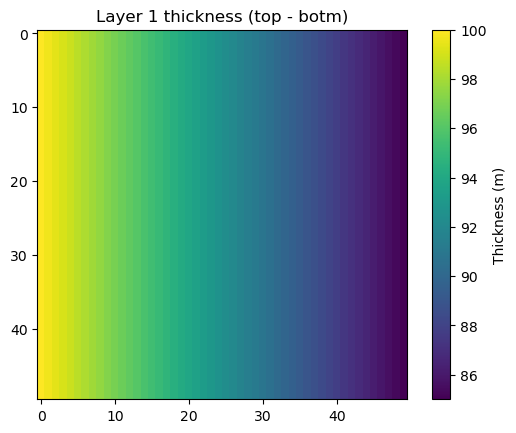

In [47]:

top_arr = dis.top.array
botm_arr = dis.botm.array

print("top shape :", top_arr.shape)
print("botm shape:", botm_arr.shape)

thk = top_arr - botm_arr[0, :, :]
print("Thickness stats (m): min/mean/max =", float(thk.min()), float(thk.mean()), float(thk.max()))

plt.figure()
plt.title("Layer 1 thickness (top - botm)")
plt.imshow(thk)
plt.colorbar(label="Thickness (m)")
plt.show()

### View what will be written to the `.dis` file

FloPy can show you the text that will go into the package file.  
This is a **great debugging and learning** trick.

In [48]:
# dis.write_file()  # writes the .dis file only
dis_path = Path(dis.parent.model_ws) / dis.file_name[0]
print("Wrote:", dis_path)
print(dis_path.read_text()[:1200])  # first ~1200 characters

Wrote: /workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/zz_Practice_MODFLOW/dis_tutorial_ws/dis_1layer_demo.dis
# DIS package for MODFLOW-2005 generated by Flopy 3.10.0
         1        50        50         1         4         2
  0
CONSTANT    1.000000E+02                           #delr                          
CONSTANT    1.000000E+02                           #delc                          
INTERNAL               1  (50E15.6) -1 #model_top                     
   1.000000E+02   9.969388E+01   9.938776E+01   9.908163E+01   9.877551E+01   9.846939E+01   9.816327E+01   9.785714E+01   9.755102E+01   9.724490E+01   9.693877E+01   9.663265E+01   9.632653E+01   9.602041E+01   9.571429E+01   9.540816E+01   9.510204E+01   9.479592E+01   9.448980E+01   9.418367E+01   9.387755E+01   9.357143E+01   9.326530E+01   9.295918E+01   9.265306E+01   9.234694E+01   9.204082E+01   9.173470E+01   9.142857E+01   9.112245E+01   9.081633E+01   9.051020E+01   9.020408E+01   8.989796E+01  

## 4) “What if”: Convert to a **three-layer** model

This is the common “next step” in layered model learning:
- You increase **nlay**
- Provide a bottom for each layer via `botm` (shape `(nlay, nrow, ncol)`)

### One simple way:
Pick two intermediate bottoms (e.g., 35 m and 25 m above datum), then the final bottom at 0 m.

> **Important:** For physically valid layering you must have:
`top >= botm[0] >= botm[1] >= ... >= botm[nlay-1]` everywhere.

Layer thickness means: [42.5, 15.0, 35.0]


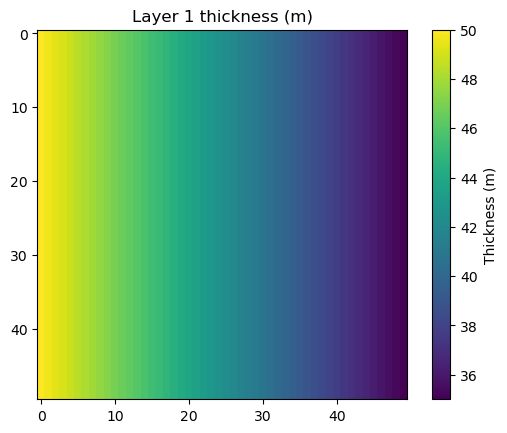

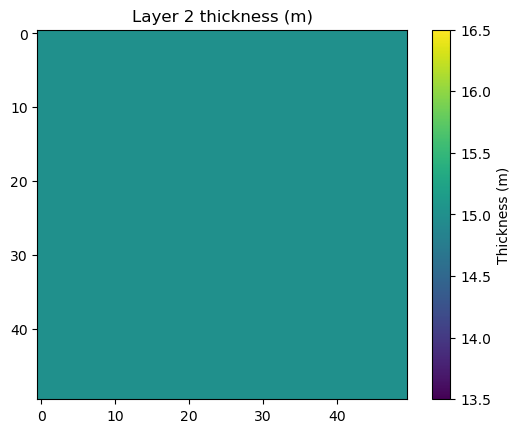

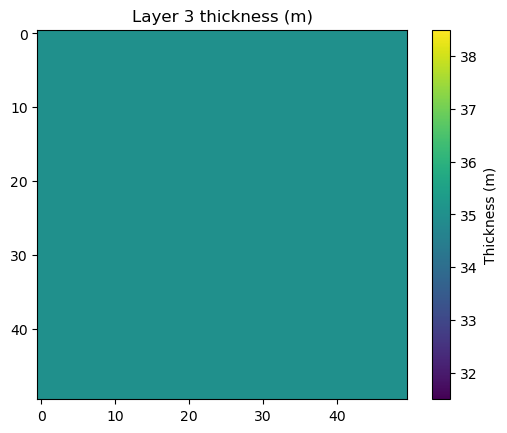

In [49]:

# Make a NEW model so we don't overwrite the prior one
m3 = flopy.modflow.Modflow(
    modelname="dis_3layer_demo",
    exe_name=mf_exe,
    model_ws=str(workspace),
)

nlay3 = 3
botm3 = np.zeros((nlay3, nrow, ncol))
botm3[0, :, :] = 50.0   # bottom of layer 1
botm3[1, :, :] = 35.0   # bottom of layer 2
botm3[2, :, :] = 0.0    # bottom of layer 3

dis3 = flopy.modflow.ModflowDis(
    model=m3,
    nlay=nlay3, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy,
    top=ztop,
    botm=botm3,
    nper=nper, perlen=perlen, nstp=nstp, tsmult=tsmult, steady=steady,
    itmuni=4, lenuni=2,
)

# thickness by layer
top0 = dis3.top.array
bot = dis3.botm.array
thk_layers = np.zeros((nlay3, nrow, ncol))
thk_layers[0] = top0 - bot[0]
thk_layers[1] = bot[0] - bot[1]
thk_layers[2] = bot[1] - bot[2]

print("Layer thickness means:", [float(thk_layers[k].mean()) for k in range(nlay3)])

for k in range(nlay3):
    plt.figure()
    plt.title(f"Layer {k+1} thickness (m)")
    plt.imshow(thk_layers[k])
    plt.colorbar(label="Thickness (m)")
    plt.show()

## 5) Visualize a cross-section (DIS geometry)

A cross-section helps you *see* how `top` and `botm` define the grid.

Here we plot a cross-section along the middle row (roughly west → east).

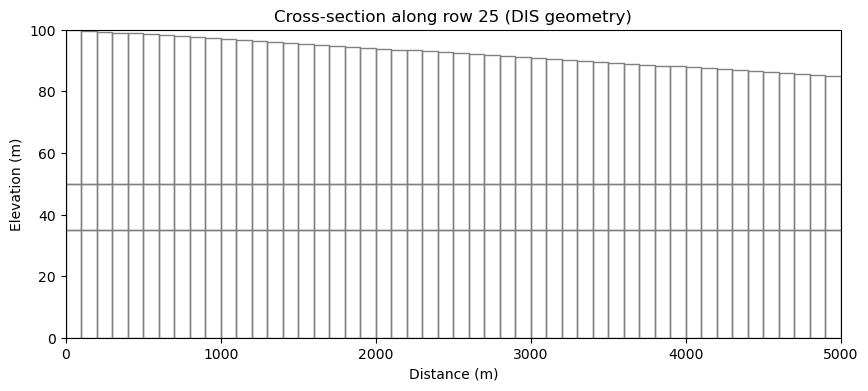

In [50]:

import flopy.plot as fplt

row_mid = nrow // 2

fig, ax = plt.subplots(figsize=(10, 4))
xsec = fplt.PlotCrossSection(model=m3, line={"row": row_mid}, ax=ax)
xsec.plot_grid()
ax.set_title(f"Cross-section along row {row_mid} (DIS geometry)")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Elevation (m)")
plt.show()

## 6) Non-uniform grid spacing (optional but very useful)

In MODFLOW DIS, **delr** and **delc** can be:
- a scalar (uniform spacing), or
- arrays (variable spacing)

This is commonly used to **refine around a well** or a boundary.

Below we create a refined zone in the center by shrinking cell sizes there.

Total model length in x (m): 4500.0
Total model length in y (m): 4500.0


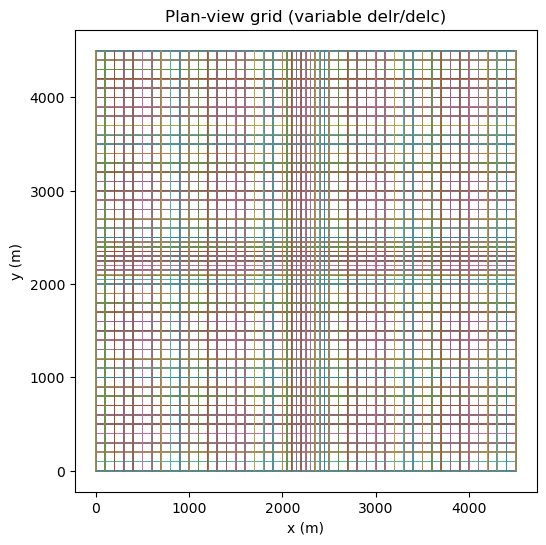

In [51]:

# Example: variable delr/delc (still totals to ~same domain size)
# Start with 100 m everywhere
delr = np.ones(ncol) * 100.0
delc = np.ones(nrow) * 100.0

# Refine a central band (make cells smaller)
center_band = slice(ncol//2 - 5, ncol//2 + 5)
delr[center_band] = 50.0  # finer columns
delc[center_band] = 50.0  # finer rows

print("Total model length in x (m):", delr.sum())
print("Total model length in y (m):", delc.sum())

mvar = flopy.modflow.Modflow(
    modelname="dis_variable_grid_demo",
    exe_name=mf_exe,
    model_ws=str(workspace),
)

dis_var = flopy.modflow.ModflowDis(
    model=mvar,
    nlay=1, nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=ztop,
    botm=np.array([np.full((nrow, ncol), zbot)]),
    nper=nper, perlen=perlen, nstp=nstp, tsmult=tsmult, steady=steady,
    itmuni=4, lenuni=2,
)

fig, ax = plt.subplots(figsize=(6, 6))
mg = dis_var.parent.modelgrid
mg.set_coord_info(xoff=0.0, yoff=0.0)

# Plot grid lines quickly
xv, yv = np.meshgrid(mg.xvertices, mg.yvertices)
for j in range(yv.shape[0]):
    ax.plot(xv[j, :], yv[j, :], linewidth=0.5)
for i in range(xv.shape[1]):
    ax.plot(xv[:, i], yv[:, i], linewidth=0.5)

ax.set_aspect("equal")
ax.set_title("Plan-view grid (variable delr/delc)")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.show()

## 7) “What if”: Make it transient (DIS time discretization)

Steady-state uses `steady=[True]`. For transient, set `steady=[False]` and provide:
- **perlen** (period lengths)
- **nstp** (timesteps per period)
- **tsmult** (optional; timestep growth)

Below is a standard teaching example:
- Stress Period 1: steady-state “spin-up”
- Stress Period 2: transient response (e.g., pumping/recharge changes)

We are only building DIS here; later package notebooks will show how transient interacts with storage (LPF/BCF) and stresses (WEL/RCH/RIV).

In [52]:

mtran = flopy.modflow.Modflow(
    modelname="dis_transient_demo",
    exe_name=mf_exe,
    model_ws=str(workspace),
)

nper_t = 2
perlen_t = [1.0, 30.0]     # days
nstp_t   = [1, 30]         # daily steps in period 2
tsmult_t = [1.0, 1.0]
steady_t = [True, False]   # spin-up then transient

dis_t = flopy.modflow.ModflowDis(
    model=mtran,
    nlay=1, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy,
    top=ztop,
    botm=np.array([np.full((nrow, ncol), zbot)]),
    nper=nper_t, perlen=perlen_t, nstp=nstp_t, tsmult=tsmult_t, steady=steady_t,
    itmuni=4, lenuni=2,
)
from pathlib import Path

dis_t.write_file()
dis_path = Path(dis.parent.model_ws) / dis.file_name[0]
print("Wrote:", dis_path)
print(dis_path.read_text()[:1200])

Wrote: /workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/zz_Practice_MODFLOW/dis_tutorial_ws/dis_1layer_demo.dis
# DIS package for MODFLOW-2005 generated by Flopy 3.10.0
         1        50        50         1         4         2
  0
CONSTANT    1.000000E+02                           #delr                          
CONSTANT    1.000000E+02                           #delc                          
INTERNAL               1  (50E15.6) -1 #model_top                     
   1.000000E+02   9.969388E+01   9.938776E+01   9.908163E+01   9.877551E+01   9.846939E+01   9.816327E+01   9.785714E+01   9.755102E+01   9.724490E+01   9.693877E+01   9.663265E+01   9.632653E+01   9.602041E+01   9.571429E+01   9.540816E+01   9.510204E+01   9.479592E+01   9.448980E+01   9.418367E+01   9.387755E+01   9.357143E+01   9.326530E+01   9.295918E+01   9.265306E+01   9.234694E+01   9.204082E+01   9.173470E+01   9.142857E+01   9.112245E+01   9.081633E+01   9.051020E+01   9.020408E+01   8.989796E+01  

## 8) Mini checklist + common pitfalls

**Checklist**
- `top` is `(nrow, ncol)` and `botm` is `(nlay, nrow, ncol)`
- Layer ordering makes sense everywhere (`top >= botm[0] >= botm[1] ...`)
- `nper == len(perlen) == len(nstp) == len(tsmult) == len(steady)`
- Units are consistent (K, recharge, pumping, geometry, time)

**Common pitfalls**
- Accidentally flipping row/col dimensions
- `botm` values higher than `top` somewhere (negative thickness)
- Mismatched stress-period lists
- Using meters for geometry but seconds for K (or vice versa)

## 9) Exercises (quick “do it yourself”)

1. **Add a fourth layer** by inserting a new `botm` surface.
2. Make the topography a **valley** instead of a slope (e.g., quadratic profile in x).
3. Create **grid refinement** near a hypothetical well by shrinking `delr/delc` locally.
4. Create **3 stress periods**: steady, transient, transient (and inspect the `.dis` entry).

When you’re ready, tell me what you want improved or expanded in this DIS notebook, and we’ll iterate until you’re satisfied. Then we’ll move to **BAS6** next.